In [1]:
using SymPy

In [100]:
using PyPlot

In [2]:
function grad(f, x)
    [diff(f, x[i]) for i in 1:length(x)]
end

grad (generic function with 1 method)

In [158]:
function define_field(x, phi, vs, lambdas, betas)
    num_points = length(lambdas)
    @assert size(vs, 1) == length(lambdas)
    @assert size(betas, 1) == length(lambdas)
    @assert num_points >= 1
    
    d = 0 * lambdas[1]
    for i = 1:num_points
        phi_expr = phi(norm(x - vec(vs[i,:])))
        d += lambdas[i] * phi_expr + dot(vec(betas[i,:]), grad(phi_expr, x))[1]
    end
    d
end

define_field (generic function with 1 method)

In [176]:
points = [1 0; 0 1; -1 0; 0 -1]
normals = [1 1; 0 1; -1 1; 0 -1]

4x2 Array{Int64,2}:
  1   1
  0   1
 -1   1
  0  -1

In [304]:
points[1,:]

1x2 Array{Int64,2}:
 1  0

In [282]:
using ProfileView

INFO: Precompiling module ProfileView...
INFO: Precompiling module ProfileViewSVG...


In [302]:
using PyCall

In [303]:
@pyimport sympy

LoadError: LoadError: @pyimport: sympy already defined
while loading In[303], in expression starting on line 326

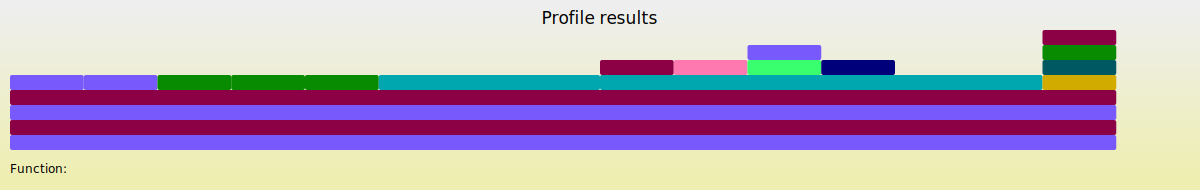

0.016645 seconds (58.40 k allocations: 6.958 MB)


In [301]:
dimension = 2
num_points = size(points, 1)
lambdas = Sym[symbols("lambda$(i)", real=true) for i in 1:num_points]
x = Sym[symbols("x$(i)", real=true) for i in 1:dimension]
vs = Sym[symbols("v$(j)_$(i)", real=true) for j in 1:num_points, i in 1:dimension]
betas = Sym[symbols("beta$(j)_$(i)", real=true) for j in 1:num_points, i in 1:dimension]
phi = x -> x^3
d = define_field(x, phi, vs, lambdas, betas)

# Define A and b such that A * [lambdas; betas[:]] = b
# A has 1 row for each point and dim rows for each normal

A_generator = Array{Function}(num_points * (dimension + 1), num_points * (dimension + 1))
b = zeros(num_points * (dimension + 1))

row = 1
for i = 1:num_points
    col = 1
    d_at_v_i = d([x[k] => vs[i,k] for k = 1:dimension]...)
    for j = 1:num_points
        A_generator[row, col] = lambdify(diff(d_at_v_i, lambdas[j]), vs[:])
        col += 1
    end
    for j = 1:num_points
        for k = 1:dimension
            A_generator[row, col] = lambdify(diff(d_at_v_i, betas[j,k]), vs[:])
            col += 1
        end
    end
    b[row] = 0.0
    row += 1
end

g = grad(d, x)

for i = 1:num_points
    for k = 1:dimension
        col = 1
        for j = 1:num_points
            expr = diff(g[k], lambdas[j])([x[l] => vs[i,l] for l = 1:dimension]...)
            if expr == 0.0 || isnan(expr)
                A_generator[row, col] = (x...) -> 0.0
            else
                A_generator[row, col] = lambdify(expr, vs[:])
            end
            col += 1
        end
        for j = 1:num_points
            for l = 1:dimension
                expr = diff(g[k], betas[j,l])([x[l] => vs[i,l] for l = 1:dimension]...)
                if expr == 0.0 || isnan(expr)
                    A_generator[row, col] = (x...) -> 0.0
                else
                    A_generator[row, col] = lambdify(expr, vs[:])
                end
                col += 1
            end
        end
        b[row] = normals[i,k]
        row += 1
    end
end

d_lambda = lambdify(d, vcat(x, vs[:], lambdas, betas[:]))
for i = 1:size(A_generator, 1)
    for j = 1:size(A_generator, 2)
        A_generator[i,j](points...)
    end
end


Profile.clear()
@time @profile for i = 1:100
    A_2 = similar(A_generator, Float64)
    for i = 1:size(A_generator, 1)
        for j = 1:size(A_generator, 2)
            A_2[i,j] = A_generator[i,j](points...)
        end
    end

    y = A_2 \ b
    lambda_values = y[1:num_points]
    beta_values = reshape(y[num_points+1:end], dimension, num_points)'
    d_result = (x...) -> d_lambda(vcat(collect(x), points[:], lambda_values, beta_values[:])...)
end
ProfileView.view()

In [274]:
@which lambdify(x[1])

lambdify(ex::SymPy.Sym) at /home/rdeits/.julia/v0.4/SymPy/src/lambdify.jl:114

In [267]:
# @time for i = 1:10
    
A = zeros(0, num_points * (dimension + 1))
b = zeros(0, 1)
for i = 1:num_points
    d_at_v_i = d_at_points([x[k] => points[i,k] for k = 1:dimension]...)
    row = zeros(num_points * (dimension + 1))
    row_index = 1
    for j = 1:num_points
        row[row_index] = diff(d_at_v_i, lambdas[j])
        row_index += 1
    end
    for j = 1:num_points
        for k = 1:dimension
            row[row_index] = diff(d_at_v_i, betas[j,k])
            row_index += 1
        end
    end
    A = [A; row']
    b = [b; 0]
end

g_at_points = grad(d_at_points, x)
for i = 1:num_points
    for k = 1:dimension
        row = zeros(num_points * (dimension + 1))
        row_index = 1
        for j = 1:num_points
            row[row_index] = diff(g_at_points[k], lambdas[j])([x[l] => points[i,l] for l = 1:dimension]...)
            row_index += 1
        end
        for j = 1:num_points
            for l = 1:dimension
                row[row_index] = diff(g_at_points[k], betas[j,l])([x[l] => points[i,l] for l = 1:dimension]...)
                if isnan(row[row_index])
                    row[row_index] = 0.0
                end
                row_index += 1
            end
        end
        A = [A; row']
        b = [b; normals[i,k]]
    end
end

y = A \ b
lambda_values = y[1:num_points]
d_result = d([vs[i,j] => points[i,j] for i = 1:num_points, j = 1:dimension]...)
beta_values = reshape(y[num_points+1:end], dimension, num_points)'
d_result = d_result(Dict(zip(lambdas, lambda_values))...)
d_result = d_result(Dict(zip(betas[:], beta_values[:]))...)
d_result = lambdify(d_result, x)
# end

##17242 (generic function with 1 method)

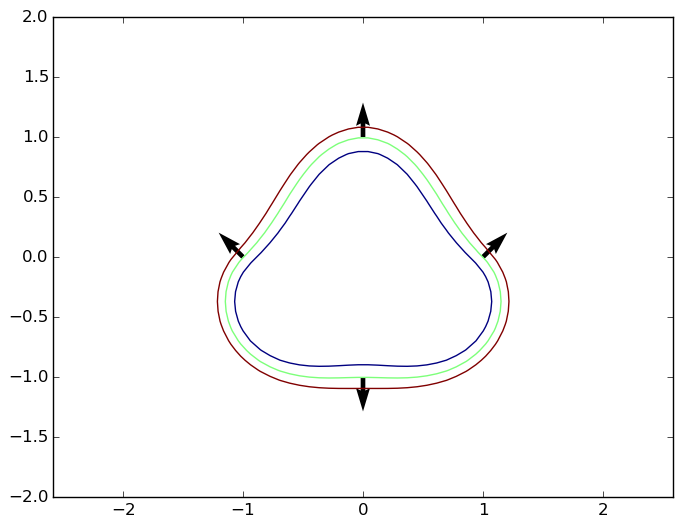

(-2.0,2.0,-2.0,2.0)

0.059471 seconds (192.01 k allocations: 8.110 MB)


In [298]:
X = linspace(-2, 2)
Y = linspace(-2, 2)
Z = zeros(length(X), length(Y))

@time for i = 1:length(X)
    for j = 1:length(Y)
        Z[j,i] = d_result(X[i], Y[j])
    end
end
clf()
hold(true)
PyPlot.contour(X, Y, Z, [-0.1, 0.0, 0.1])
for i = 1:num_points
    PyPlot.quiver(points[i,:]..., normals[i,:]...)
end
axis("equal")